# Forecasting Consensus Expectations: Initial Jobless Claims
## Point and Directional Forecasts

**Imports**

In [10]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown

In [3]:
OUT_DIR = "../out"
DF_FILE       = "ijc_df.parquet"
DF_FULL_FILE  = "ijc_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (180723, 10)
df_full shape: (213693, 10)


In [5]:
df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise
0,2006-01-05,2005-12-31,320.0,291.0,Michelle Meyer,Mastercard International Inc,NaN,NaT,NaN,-29.0
1,2006-01-05,2005-12-31,320.0,291.0,Michael Derks,Fxpro Financial Services Ltd,NaN,NaT,NaN,-29.0
2,2006-01-05,2005-12-31,320.0,291.0,Michael E Feroli,JP Morgan Securities LLC,NaN,NaT,NaN,-29.0
3,2006-01-05,2005-12-31,320.0,291.0,Michael Gapen,Morgan Stanley & Co LLC,NaN,NaT,NaN,-29.0
4,2006-01-05,2005-12-31,320.0,291.0,Michael Moran,Daiwa Capital Mkts,NaN,NaT,NaN,-29.0


**Data Exploration**

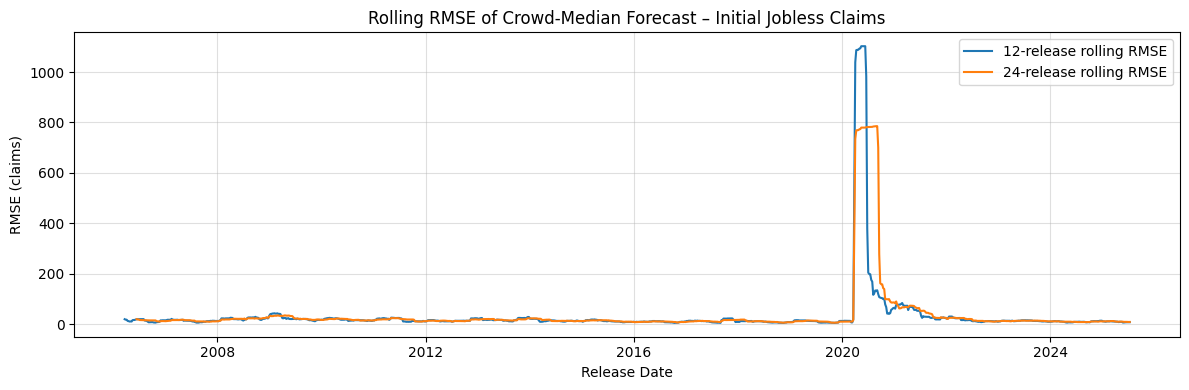

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. One row per release: crowd median vs actual
# ------------------------------------------------------------
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),   # ← economist median
                actual      =("actual",   "first"))
           .dropna()           # drop unreleased weeks
           .sort_index()
)

# ------------------------------------------------------------
# 2. Rolling RMSEs (12- and 24-release windows)
# ------------------------------------------------------------
for W in (12, 24):
    median_vs_actual[f"rmse_{W}"] = (
        median_vs_actual["crowd_median"].sub(median_vs_actual["actual"])
        .rolling(W, min_periods=W)
        .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
    )

# ------------------------------------------------------------
# 3. Plot
# ------------------------------------------------------------
plt.figure(figsize=(12, 4))

plt.plot(median_vs_actual.index,
         median_vs_actual["rmse_12"],
         label="12-release rolling RMSE")

plt.plot(median_vs_actual.index,
         median_vs_actual["rmse_24"],
         label="24-release rolling RMSE")

plt.title("Rolling RMSE of Crowd-Median Forecast – Initial Jobless Claims")
plt.xlabel("Release Date")
plt.ylabel("RMSE (claims)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


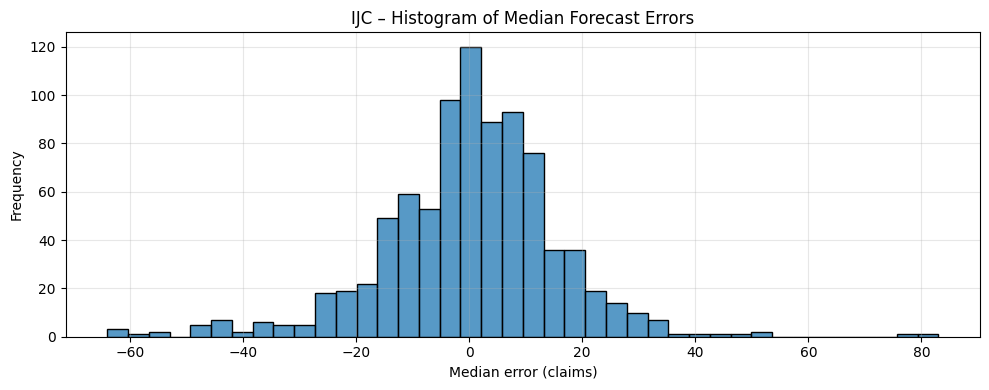

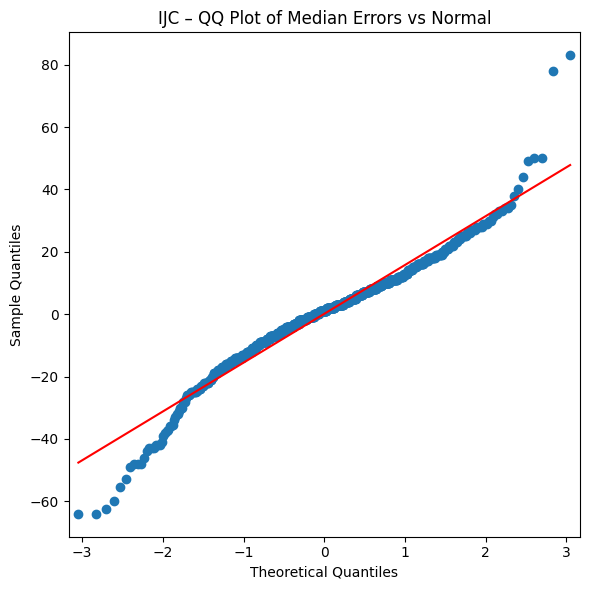


=== Tests on IJC median-forecast errors ===
Jarque-Bera     : JB =    359.53   p = 0.0000
KS vs Student-t : D  =     0.028   p = 0.4795
CvM vs Student-t: W² =     0.118   p = 0.5055


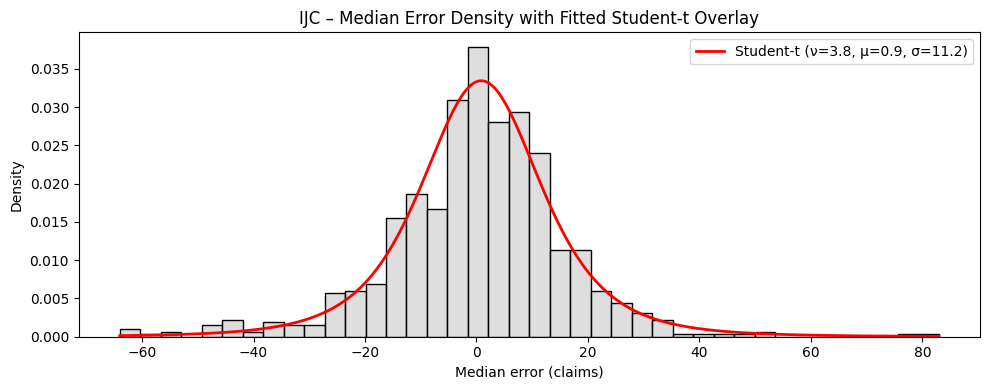

In [9]:
# ░░ Diagnostics for IJC median-forecast errors ░░

# ------------------------------------------------------------------
# 1 ▸ build release-level median error series
# ------------------------------------------------------------------
def get_median_errors(panel: pd.DataFrame) -> np.ndarray:
    """
    Return 1-D numpy array of (median forecast – actual) errors,
    one value per release date, for the supplied long panel.
    """
    per_rel = (panel
               .groupby("release_date")
               .agg(median_fc=("forecast", "median"),
                    actual    =("actual",   "first"))
               .dropna(subset=["actual"]))          # exclude unreleased week(s)
    return (per_rel["median_fc"] - per_rel["actual"]).values

median_errors = get_median_errors(df)          # or df for COVID-filtered

# ------------------------------------------------------------------
# 2 ▸ histogram of median errors
# ------------------------------------------------------------------
plt.figure(figsize=(10, 4))
sns.histplot(median_errors, bins=40, edgecolor="black")
plt.title("IJC – Histogram of Median Forecast Errors")
plt.xlabel("Median error (claims)")
plt.ylabel("Frequency")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3 ▸ QQ plot vs Normal
# ------------------------------------------------------------------
plt.figure(figsize=(6, 6))
sm.qqplot(median_errors, line="s", ax=plt.gca())
plt.title("IJC – QQ Plot of Median Errors vs Normal")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4 ▸ normality & Student-t GOF tests
# ------------------------------------------------------------------
jb_stat, jb_p = st.jarque_bera(median_errors)

nu_hat, loc_hat, scale_hat = st.t.fit(median_errors)            # Student-t MLE
ks_stat, ks_p = st.kstest(median_errors, 't',
                          args=(nu_hat, loc_hat, scale_hat))

cvm_res = st.cramervonmises(
    median_errors,
    lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
)

print("\n=== Tests on IJC median-forecast errors ===")
print(f"Jarque-Bera     : JB = {jb_stat:9.2f}   p = {jb_p:.4f}")
print(f"KS vs Student-t : D  = {ks_stat:9.3f}   p = {ks_p:.4f}")
print(f"CvM vs Student-t: W² = {cvm_res.statistic:9.3f}   p = {cvm_res.pvalue:.4f}")

# ------------------------------------------------------------------
# 5 ▸ histogram + fitted Student-t PDF overlay
# ------------------------------------------------------------------
xgrid = np.linspace(median_errors.min(), median_errors.max(), 400)
pdf_t = st.t.pdf(xgrid, df=nu_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10, 4))
sns.histplot(median_errors, bins=40, stat="density",
             edgecolor="black", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2,
         label=f"Student-t (ν={nu_hat:.1f}, μ={loc_hat:.1f}, σ={scale_hat:.1f})")
plt.title("IJC – Median Error Density with Fitted Student-t Overlay")
plt.xlabel("Median error (claims)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



COVID-filtered:
  Pearson  r  =  0.346   p = 0.0000
  Spearman ρ  =  0.327   p = 0.0000

Full sample:
  Pearson  r  =  0.751   p = 0.0000
  Spearman ρ  =  0.403   p = 0.0000


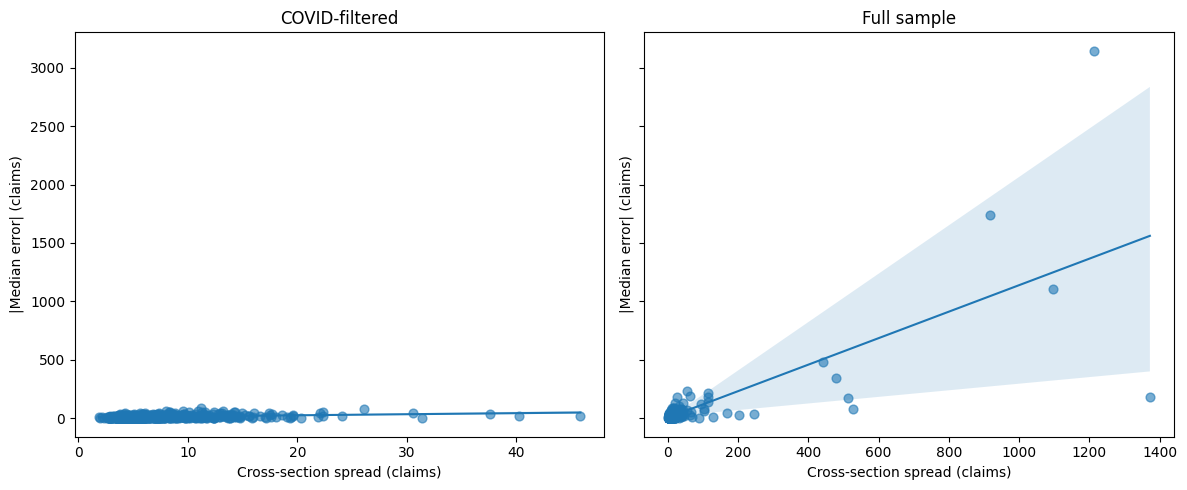

In [13]:
# %% [markdown]
# ░░ Spread → |Median Error| diagnostics (IJC) ░░
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
import statsmodels.api as sm

# ------------------------------------------------------------------
# 1 ▸ helper: release-level spread & |median error|
# ------------------------------------------------------------------
def spread_tbl(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    spread = (panel.groupby("release_date")["forecast"]
                    .std(ddof=0).rename("spread"))
    med_act = (panel.groupby("release_date")
                     .agg(median_fc=("forecast", "median"),
                          actual    =("actual",   "first")))
    med_act["abs_err"] = (med_act["median_fc"] - med_act["actual"]).abs()
    out = med_act.join(spread).reset_index()
    out["panel"] = label
    return out.dropna(subset=["spread", "abs_err"])

covid_tbl = spread_tbl(df,       "COVID")
full_tbl  = spread_tbl(df_full,  "Full")

# ------------------------------------------------------------------
# 2 ▸ correlations
# ------------------------------------------------------------------
for tbl, name in [(covid_tbl, "COVID-filtered"), (full_tbl, "Full sample")]:
    pear  = stats.pearsonr(tbl["spread"], tbl["abs_err"])
    spear = stats.spearmanr(tbl["spread"], tbl["abs_err"])
    print(f"\n{name}:")
    print(f"  Pearson  r  = {pear.statistic:6.3f}   p = {pear.pvalue:.4f}")
    print(f"  Spearman ρ  = {spear.statistic:6.3f}   p = {spear.pvalue:.4f}")

# ------------------------------------------------------------------
# 3 ▸ scatter + OLS fit
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, tbl, ttl in zip(axes, [covid_tbl, full_tbl],
                        ["COVID-filtered", "Full sample"]):
    sns.regplot(data=tbl, x="spread", y="abs_err",
                scatter_kws=dict(alpha=0.6, s=40),
                line_kws=dict(lw=1.5), ax=ax)
    ax.set_title(ttl)
    ax.set_xlabel("Cross-section spread (claims)")
    ax.set_ylabel("|Median error| (claims)")
plt.tight_layout(); plt.show()
